In [26]:
import os
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# root_dir = '/content/drive/My Drive/Colab Notebooks/Presentation20062024/ANNOTATION_ANNOTATEURICES'
# output_dir = '/content/drive/My Drive/Colab Notebooks/Presentation20062024/F-score-precision'
root_dir = '../ACCMAJ_MISLABELING'
output_dir = '../GOLD_SEABORN'
max_tokens=6500

# Création du dossier de sortie s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

GOLD_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv
GOLD_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
Author: DAUDET, Précision: 0.79, Rappel: 0.88, F-score: 0.83


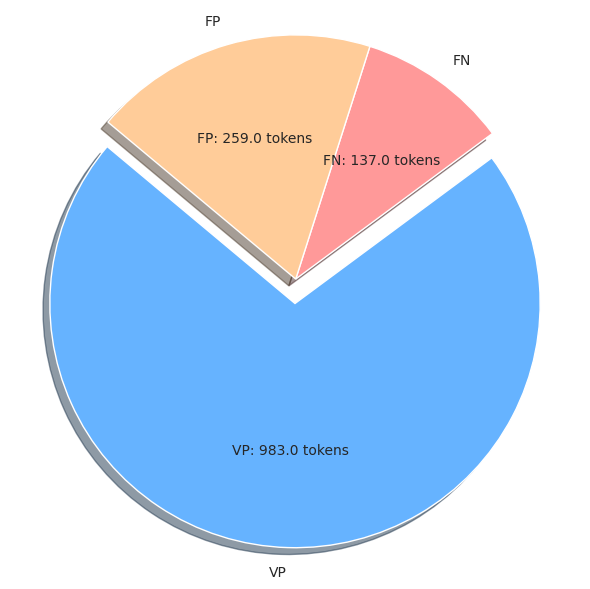

GOLD_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv
Author: CARRAUD, Précision: 0.32, Rappel: 0.61, F-score: 0.42


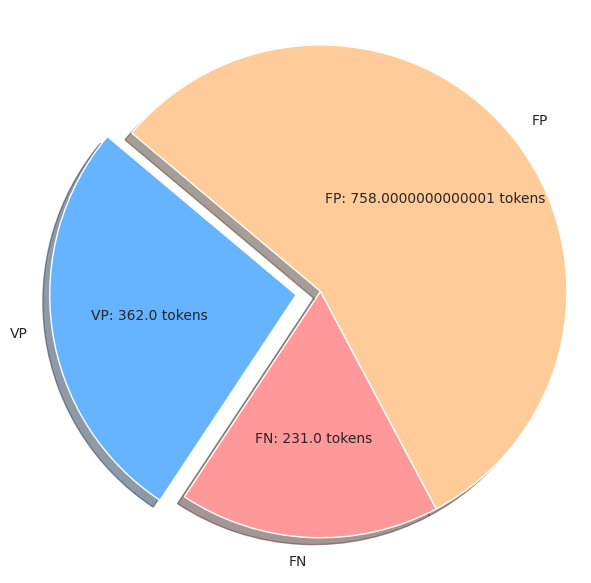

GOLD_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv
GOLD_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
Author: DAUDET, Tool: Kraken-base_spaCy3.7.2-lg, Précision: 0.79, Rappel: 0.88, F-score: 0.83
GOLD_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv
GOLD_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_DAUDET_petit-chose_REF_spaCy3.7.2-lg.csv.aia.csv
Author: DAUDET, Tool: REF_spaCy3.7.2-lg, Précision: 0.85, Rappel: 0.81, F-score: 0.83
GOLD_CARRAUD_petite-Jeanne_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_REF_spaCy3.7.2-lg.csv.aia.csv
GOLD_CARRAUD_petite-Jeanne_TesseractFra-PNG_spaCy3.7.2-lg.csv.aia.csv
GOLD_DAUDET_petit-chose_Kraken-base_spaCy3.7.2-lg.csv.aia.csv
GOLD

In [28]:
# Initialiser les compteurs globaux
def init_counters():
    return {
        'total_en': 0,
        'vp_count': 0,
        'fn_count': 0,
        'fp_na_count': 0,
        'fp_label_error_count': 0,
        'fp_na_labels': {},
        'fp_label_error_labels': {},
        'token_count': 0,  # Ajouter un compteur de tokens
        'tokens_vp': 0,
        'tokens_fn': 0,
        'tokens_fp': 0,
        'tokens_fp_na': {},
        'tokens_fp_label_error': {}
    }

# Fonction pour traiter chaque fichier CSV
def process_csv_file(file_path, counters, max_tokens=6500):
    unique_annotations = set()

    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file, delimiter=';')

        for row in reader:
            if counters['token_count'] >= max_tokens:
                return

            token = row['Token']
            label = row['Label']
            # correction = row['Correction']
            correction = row['gold']
            

            # Créer une clé unique pour chaque annotation
            annotation_key = (token, label, correction)

            if annotation_key not in unique_annotations:
                unique_annotations.add(annotation_key)
                counters['token_count'] += 1

                if label or correction:
                    counters['total_en'] += 1

                    if correction and correction != 'NA' and not label:
                        counters['fn_count'] += 1
                        counters['tokens_fn'] += 1
                    elif not correction and label:
                        counters['vp_count'] += 1
                        counters['tokens_vp'] += 1
                    elif correction and label:
                        if correction == 'NA':
                            counters['fp_na_count'] += 1
                            counters['tokens_fp'] += 1
                            if label in counters['fp_na_labels']:
                                counters['fp_na_labels'][label] += 1
                                counters['tokens_fp_na'][label] += 1
                            else:
                                counters['fp_na_labels'][label] = 1
                                counters['tokens_fp_na'][label] = 1
                        else:
                            counters['fp_label_error_count'] += 1
                            counters['tokens_fp'] += 1
                            if label in counters['fp_label_error_labels']:
                                counters['fp_label_error_labels'][label] += 1
                                counters['tokens_fp_label_error'][label] += 1
                            else:
                                counters['fp_label_error_labels'][label] = 1
                                counters['tokens_fp_label_error'][label] = 1

# Fonction pour créer un camembert des FP
def create_fp_pie_chart(counters, output_path):
    total_fp = counters['fp_na_count'] + counters['fp_label_error_count']
    fp_na_proportion = counters['fp_na_count'] / total_fp if total_fp else 0
    fp_label_error_proportion = counters['fp_label_error_count'] / total_fp if total_fp else 0

    labels_fp = list(counters['fp_na_labels'].keys()) + list(counters['fp_label_error_labels'].keys())
    sizes_fp = list(counters['fp_na_labels'].values()) + list(counters['fp_label_error_labels'].values())
    colors_fp = ['#4682B4'] * len(counters['fp_na_labels']) + ['#B0C4DE'] * len(counters['fp_label_error_labels'])

    # Création du camembert
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(sizes_fp, startangle=90, colors=colors_fp, wedgeprops=dict(edgecolor='w'), autopct='%1.1f%%')


    # Ajout des annotations pour les labels initiaux
    for i, label in enumerate(labels_fp):
        autotexts[i].set_text(f'{label}: {sizes_fp[i]} tokens')

    # Ajout de la légende
    legend_labels = ['FP: non entité', 'FP: entité mal labellisée']
    ax.legend([wedges[0], wedges[len(counters['fp_na_labels'])]], legend_labels, loc="best")
    ax.axis('equal')

    # Enregistrer le camembert
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Fonction pour créer un camembert des proportions VP, FN, FP
def create_proportion_pie_chart(counters, output_path):
    total_en = counters['total_en']
    vp_proportion = counters['vp_count'] / total_en if total_en else 0
    fn_proportion = counters['fn_count'] / total_en if total_en else 0
    fp_proportion = (counters['fp_na_count'] + counters['fp_label_error_count']) / total_en if total_en else 0

    labels_total = ['VP', 'FN', 'FP']
    sizes_total = [vp_proportion, fn_proportion, fp_proportion]
    colors_total = ['#66b3ff', '#ff9999', '#ffcc99']
    explode_total = (0.1, 0, 0)  # "explode" la première partie

    # Création du camembert
    plt.figure(figsize=(6, 6))
    patches, texts, autotexts = plt.pie(sizes_total, explode=explode_total, labels=labels_total, colors=colors_total, autopct='%1.1f%%',
            shadow=True, startangle=140)

    # Ajout des annotations pour les proportions
    for i, label in enumerate(labels_total):
        autotexts[i].set_text(f'{label}: {sizes_total[i]*total_en} tokens')

    plt.axis('equal')

    # Enregistrer le camembert
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# Fonction pour calculer les métriques de performance et sauvegarder les résultats en JSON
def calculate_metrics_and_save_json(counters, output_path):
    # Extraction des valeurs
    vp = counters['vp_count']
    fn = counters['fn_count']
    fp = counters['fp_na_count'] + counters['fp_label_error_count']

    # Précision
    precision = vp / (vp + fp) if (vp + fp) > 0 else 0

    # Rappel
    recall = vp / (vp + fn) if (vp + fn) > 0 else 0

    # F1-score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Enregistrer les résultats en JSON
    results = {
        'Precision': precision,
        'Recall': recall,
        'F-score': f1,
        'Total Tokens': counters['token_count'],
        'Tokens VP': counters['tokens_vp'],
        'Tokens FN': counters['tokens_fn'],
        'Tokens FP': counters['tokens_fp'],
        'Tokens FP (NA)': counters['tokens_fp_na'],
        'Tokens FP (Label Error)': counters['tokens_fp_label_error']
    }

    with open(output_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)

    return precision, recall, f1

# Traitement pour chaque configuration et enregistrement des résultats
def process_annotations_and_generate_results(author=None, tool=None, max_tokens=6500):
    counters = init_counters()
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            print(file)
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                if author and author not in file_path:
                    continue
                if tool and tool not in file_path:
                    continue
                process_csv_file(file_path, counters, max_tokens=max_tokens)
                if counters['token_count'] >= max_tokens:
                    break
        if counters['token_count'] >= max_tokens:
            break

    # Calculer les métriques et enregistrer les résultats en JSON
    precision, recall, f1 = calculate_metrics_and_save_json(counters, os.path.join(output_dir, f'{author}_{tool}_metrics.json'))
    return counters, precision, recall, f1

# Générer les camemberts et les métriques pour DAUDET et CARRAUD
authors = ['DAUDET', 'CARRAUD']
for author in authors:
    counters, precision, recall, f1 = process_annotations_and_generate_results(author=author)
    print(f'Author: {author}, Précision: {precision:.2f}, Rappel: {recall:.2f}, F-score: {f1:.2f}')
    create_proportion_pie_chart(counters, os.path.join(output_dir, f'SET_proportions-EN_{author}.png'))
    # create_fp_pie_chart(counters, os.path.join(output_dir, f'SET_proportions-fp-labels_{author}.png'))

# Générer les camemberts et les métriques pour chaque outil utilisé par DAUDET et CARRAUD
tools = ['Kraken-base_spaCy3.7.2-lg', 'REF_spaCy3.7.2-lg', 'TesseractFra-PNG_spaCy3.7.2-lg']
for author in authors:
    for tool in tools:
        counters, precision, recall, f1 = process_annotations_and_generate_results(author=author, tool=tool)
        print(f'Author: {author}, Tool: {tool}, Précision: {precision:.2f}, Rappel: {recall:.2f}, F-score: {f1:.2f}')
        # create_proportion_pie_chart(counters, os.path.join(output_dir, f'SET_proportions-EN_{author}_{tool}.png'))
#         # create_fp_pie_chart(counters, os.path.join(output_dir, f'SET_proportions-fp-labels_{author}_{tool}.png'))
